In [1]:
using LinearAlgebra, Statistics, Plots, CSV, DataFrames
using Optim, LsqFit

In [2]:
df = CSV.read("./temperaturas.csv", DataFrame)

Row,Tiempo (s),Sensor 1,Sensor 2,Sensor 3,Sensor 4 (ambiente)
,Float64,Float64,Float64,Float64,Float64
1,0.01,21.75,27.31,20.06,20.44
2,1.67,21.87,28.44,20.25,20.37
3,3.34,21.87,29.56,20.69,20.37
4,5.04,22.0,30.69,21.56,20.44
5,6.74,22.0,31.81,21.87,20.44
6,8.43,22.12,32.94,21.94,20.44
7,10.12,22.31,33.94,22.12,20.37
8,11.8,22.5,34.94,22.25,20.44
9,13.51,23.12,35.94,22.37,20.44


In [3]:
rename!(df, [:"Tiempo (s)" => :t, :"Sensor 1" => :s1, :"Sensor 2" => :s2, :"Sensor 3" => :s3, :"Sensor 4 (ambiente)" => :env])

#plot(df.t, df.s1)

Row,t,s1,s2,s3,env
,Float64,Float64,Float64,Float64,Float64
1,0.01,21.75,27.31,20.06,20.44
2,1.67,21.87,28.44,20.25,20.37
3,3.34,21.87,29.56,20.69,20.37
4,5.04,22.0,30.69,21.56,20.44
5,6.74,22.0,31.81,21.87,20.44
6,8.43,22.12,32.94,21.94,20.44
7,10.12,22.31,33.94,22.12,20.37
8,11.8,22.5,34.94,22.25,20.44
9,13.51,23.12,35.94,22.37,20.44


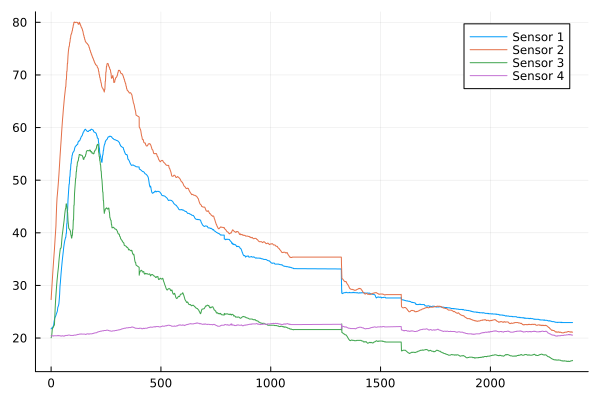

In [ ]:
#Useful values 
i1, max_s1 = findmax(df.s1)
i2, max_s2 = findmax(df.s2)
i3, max_s3 = findmax(df.s3)

plot(df.t, df.s1, label = "Sensor 1")
plot!(df.t, df.s2, label = "Sensor 2")
plot!(df.t, df.s3, label = "Sensor 3")
plot!(df.t, df.env, label = "Sensor 4")
savefig("./figura")

# Calentamiento

In [ ]:
#======================#
#  SOLUTION STRUCTURE  #
#======================#

model(t, p) = p[1] .+ (p[2]-p[1])*exp.(-p[3]*t)

#======================#
#      SENSOR 1        #
#======================#

p0_s1 = [minimum(df.s1), maximum(df.s1), 0.01]
fit_1 = curve_fit(model, df.t, df.s1, p0_s1)
new_p_s1 = fit_1.param

plot!(df.t, model(df.t, new_p_s1), label = "Auste")  

#======================#
#      SENSOR 2        #
#======================#

p0_s2 = [minimum(df.s1), maximum(df.s1), 0.01]
fit_2 = curve_fit(model, df.t, df.s1, p0_s2)
new_p_s2 = fit_2.param

plot!(df.t, model(df.t, new_p_s2), label = "Auste")  

#======================#
#      SENSOR 3        #
#======================#

p0_s2 = [minimum(df.s1), maximum(df.s1), 0.01]
fit_2 = curve_fit(model, df.t, df.s1, p0_s2)
new_p_s2 = fit_2.param

plot!(df.t, model(df.t, new_p_s2), label = "Auste") 


# Enfriamiento

In [20]:
#======================#
#  SOLUTION STRUCTURE  #
#======================#

model(t, p) = p[1] .+ (p[2]-p[1])*exp.(-p[3]*t)

#======================#
#      SENSOR 1        #
#======================#
p0_s1 = [df.s1[end], max_s1, 0.01]
fit_1 = curve_fit(model, df.t[i1:end], df.s1[i1:end], p0_s1)
new_p_s1 = fit_1.param

plot!(df.t, model(df.t, new_p_s1), label = "Ajuste Sensor 1")  

#======================#
#      SENSOR 2        #
#======================#

p0_s2 = [df.s2[end], max_s2, 0.01]
fit_2 = curve_fit(model, df.t[i2:], df.s2[i2:], p0_s2)
new_p_s2 = fit_2.param

plot!(df.t[i2:end], model(df.t[i2:end], new_p_s2), label = "Ajuste Sensor 2")  

#======================#
#      SENSOR 3        #
#======================#

p0_s3 = [minimum(df.s3), maximum(df.s3), 0.01]
fit_3 = curve_fit(model, df.t, df.s3, p0_s3)
new_p_s3 = fit_3.param

plot!(df.t, model(df.t, new_p_s3), label = "Ajuste Sensor 3") 


ArgumentError: ArgumentError: invalid index: 59.69 of type Float64

In [5]:


# Supongamos que tienes datos experimentales: tiempos y temperaturas
# tiempo = [t1, t2, t3, ...]  # en segundos
# temperatura = [T1, T2, T3, ...]  # en °C

# Ejemplo con datos simulados (reemplaza con tus datos reales)
tiempo = 0:10:300  # de 0 a 300 segundos en pasos de 10s
temperatura_ambiente = 25.0  # temperatura ambiente en °C
temperatura_inicial = 95.0   # temperatura inicial en °C
k_real = 0.02                # valor real usado para simular datos
temperatura = temperatura_ambiente .+ (temperatura_inicial - temperatura_ambiente) * exp.(-k_real * tiempo)
# Agrega algo de ruido para simular datos reales
temperatura = temperatura .+ randn(length(tiempo)) * 0.5

# Definimos el modelo para ajustar
model(t, p) = p[1] .+ (p[2] - p[1]) * exp.(-p[3] * t)

# Valores iniciales para los parámetros [Tₐ, T₀, k]
p0 = [20.0, 90.0, 0.01]

# Realizamos el ajuste
fit = curve_fit(model, tiempo, temperatura, p0)

# Parámetros ajustados
Tₐ_ajustado, T₀_ajustado, k_ajustado = fit.param

# Calculamos R²
residuales = temperatura - model(tiempo, fit.param)
ss_res = sum(residuales.^2)
ss_tot = sum((temperatura .- mean(temperatura)).^2)
r_squared = 1 - ss_res/ss_tot

# Graficamos
scatter(tiempo, temperatura, label="Datos experimentales", xlabel="Tiempo (s)", ylabel="Temperatura (°C)")
plot!(tiempo, model(tiempo, fit.param), label="Ajuste", lw=2)
title!("Ley de Enfriamiento de Newton\nk = $(round(k_ajustado, digits=5)), R² = $(round(r_squared, digits=4))")

# Mostramos resultados
println("Resultados del ajuste:")
println("Temperatura ambiente estimada (Tₐ): ", round(Tₐ_ajustado, digits=2), " °C")
println("Temperatura inicial estimada (T₀): ", round(T₀_ajustado, digits=2), " °C")
println("Constante de enfriamiento (k): ", round(k_ajustado, digits=5), " s⁻¹")
println("Coeficiente de determinación R²: ", round(r_squared, digits=4))

Resultados del ajuste:
Temperatura ambiente estimada (Tₐ): 24.71 °C
Temperatura inicial estimada (T₀): 94.8 °C
Constante de enfriamiento (k): 0.01961 s⁻¹
Coeficiente de determinación R²: 0.9996
